# Q0) Explain whether the data below are sequential or not.

- Time-Series Stock Data
- Strategy for Super Mario Brothers game
- Video Data
- Image Data such as MNIST Data

*Your Answer:*
- time-series stock data: sequential data. 주식 데이터는 시간 순으로 기록된다. 이전 시간의 값이 다음 step 값에 영향을 미치며, 데이터의 순서가 바뀔 시에 변화가 생길 것.
- strategy for super mario brothers game: sequential data. 시간에 따라 변하는 환경에 따 agent의 행동이 시간 순으로 만들어지며, 이 행동이 이후 환경에 변화를 미친다. 전략의 순서가 바뀔 시 환경이나 보상이 변한다.
- video data: sequential data. 비디오 데이터는 연속된 이미지 프레임들이 시간 순으로 나열된 형태이다. 마찬가지로 프레임들의 순서가 바뀌면 특성에 변화가 생긴다.
- image data: not sequential data. 이미지 데이터의 각 픽셀은 시간 순에 따라 나열되어 있지 않으며, 공간적 특성이 중요하다.

In [1]:
import numpy as np

# RNN

아래 RNN class는 한 개의 시점에서 RNN이 작동하는 방식을 구현해놓은 것입니다. 강의 내용과 아래 그림을 참고하여 빈칸에 알맞은 답을 채워넣어보세요.


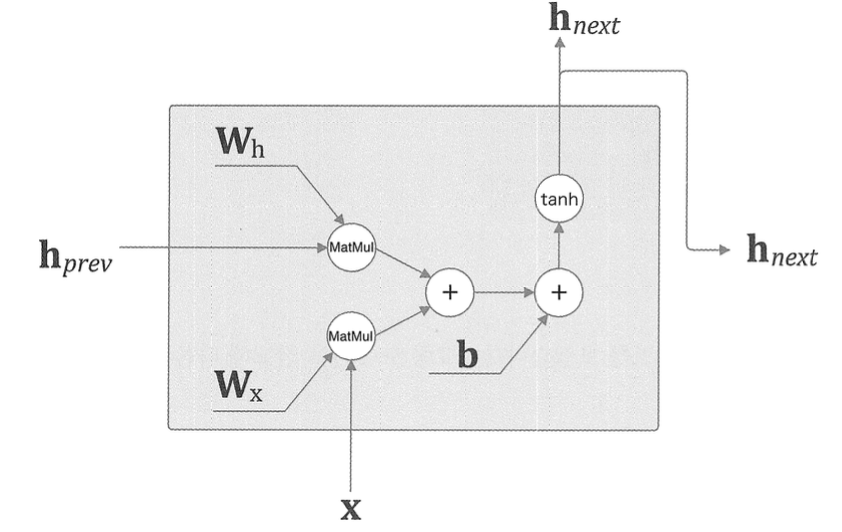


In [2]:
class RNN:
  def __init__(self, Wx, Wh, b):
    self.params = [Wx,Wh,b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.cache = None

  def forward(self, x, h_prev):
    Wx, Wh, b = self.params

    """
    문제 1: hidden state를 update할 때 행렬곱 연산을 한 후 더하는 과정에서 "이것"을 같이 더해줍니다.
    "이것"에 해당하는 것을 채워넣어주세요.
    """
    t = np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b #bias를 더해줌

    """
    문제 2: hidden state의 activation function은 무엇일까요? 다음 cell로 넘기기 위해 "빈칸"에 들어갈 적절한 값을 채워넣어주세요.
    """
    h_next = np.tanh(t) #hidden state: tanh 활성화 함수

  def backward(self, dh_next):
    Wx, Wh, b = self. params

    """
    문제 3: Backpropagation 과정에 필요한 아래 parameter들은 어디에 불러와야 할까요?
    """
    x, h_prev, h_next = self.cache #input, previous & next hidden state - cache에 저장 -> backpropagation 시 gradient 계산 위해 불려욤
    dt = dh_next * (1 - h_next ** 2)
    db = np.sum(dt, axis=0)

    """
    문제 4: 가중치 행렬 Wh의 gradient인 dWh는 전치행렬과 미분된 행렬의 행렬곱 형태로 표현됩니다.
    matmul() 함수에 적절한 값을 넣어주세요.
    """
    dWh = np.matmul(h_prev.T, dt) #loss를 current hidden state로 미분
    dh_prev = np.matmul(dt, Wh.T)
    dWx = np.matmul(x.T, dt)
    dx = np.matmul(dt, Wx.T)
    self.grads[0][...] = dWx
    self.grads[1][...] = dWh
    self.grads[2][...] = db
    return dx, dh_prev

## TIME RNN
이번에는 한 시점에서만이 아닌, T개의 time step이 주어졌을 때의 RNN layer를 살펴보도록 합시다.

"밑바닥부터 시작하는 딥러닝" 216p를 참고하세요!

In [3]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None  # 여러 time steps의 RNN cell을 리스트로 저장

        self.h = None # forward() 진행 시 마지막 RNN cell의 hidden state
        self.dh = None # backward() 진행 시 하나 앞 블록의 hidden state의 gradient
        self.stateful = stateful # False일 경우 hidden state를 영행렬로 초기화함

    def set_state(self, h):
        '''hidden state(h)를 설정하는 메서드'''
        self.h = h

    def reset_state(self):
        '''hidden state(h)를 초기화하는 메서드'''
        self.h = None

    def forward(self, xs):
        '''input으로 받는 xs는 T개 분량의 시계열 데이터'''
        Wx, Wh, b = self.params
        N, T, D = xs.shape  # N(batch), T(time steps), D(input size)
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None: # stateful=False or 처음 호출 시
            self.h = np.zeros((N, H), dtype='f') # hidden state가 영행렬로 초기화됨

        for t in range(T):
            layer = RNN(*self.params) # 앞서 구성한 RNN class를 갖고옴

            """
            문제 5: 이 반복문은 각 time step별로 RNN의 forward 메서드를 실행하고 있습니다.
            그렇다면 input으로 들어갈 xs의 2번째 차원은 무엇이 되어야 할까요?
            """
            self.h = layer.forward(xs[:, t, :], self.h) #현재 time step의 input 받도록

            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)  # 합산된 기울기
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

## Quiz 6)모델에 대한 설명이 다음과 같을 때, 총 파라미터 개수를 구해보세요.

1. Embedding을 사용하며, 단어 집합(Vocabulary)의 크기가 5,000이고 임베딩 벡터의 차원은 100입니다.

2. 은닉층에서는 Simple RNN을 사용하며, 은닉 상태의 크기는 128입니다.

3. 훈련에 사용하는 모든 샘플의 길이는 30으로 가정합니다.

4. 이진 분류를 수행하는 모델로, 출력층의 뉴런은 1개로 시그모이드 함수를 사용합니다.

5. 은닉층은 1개입니다.

*Your Answer:*
- embedding parameters: 5,000*100=50,000 (단어 집합 * 입베딩 벡터 차원)
- Simple RNN
  - weights
  - Input -> Hidden: 100*128=12,800
  - Hidden -> Hidden: 128*128=16,384
  - bias: 128
  
  =>12800+16384+128=29,312
- Output layer
  
  => 128(weights)+1(bias)=129


Total: 50,000+29,312+129=529,441

# LSTM

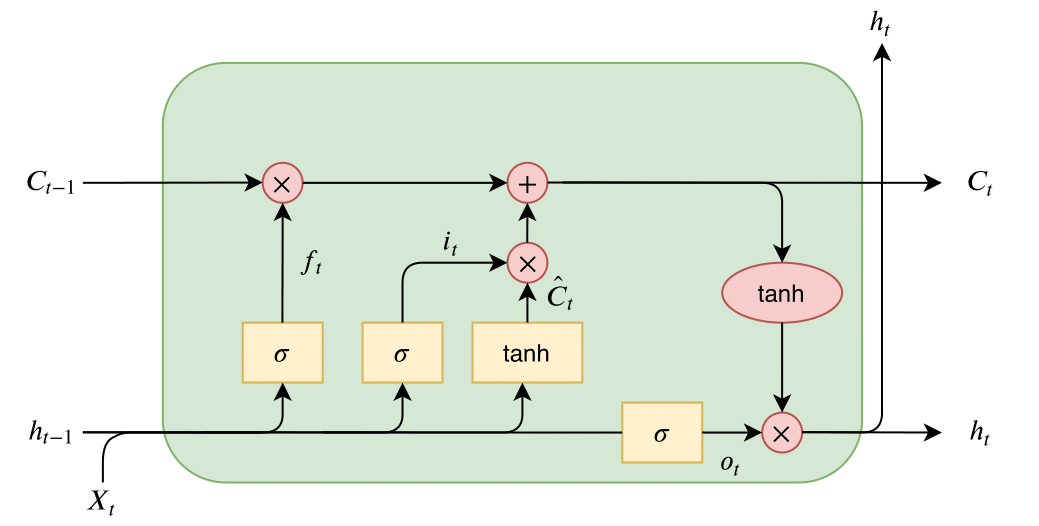

In [4]:
class sigmoid:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

In [ ]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape # hidden state 벡터 차원 수 (batch_size, 노드 수)

        # 총 4개의 게이트에서의 아핀 변환을 한 번에 계산
        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

        f = A[:, :H]  # forget gate
        g = A[:, H:2*H]  # input gate
        i = A[:, 2*H:3*H]  # input gate
        o = A[:, 3*H:]  # output gate

        """
        문제 1: 각 Gate들의 값에 activation function을 적용해주세요
        """

        f = sigmoid(f) #이전 기억 얼마나 보존/삭제할 건지
        g = np.tanh(g) #현재 입력값과 과거 hidden state 정보 요약 값
        i = sigmoid(i) #새로운 정보 얼마나 누적할 건지
        o = sigmoid(o) #input, forget gate 값들 다음 단계로 전달
        ##cell state - 장기기억/ hidden state - 단기기억

        """
        문제 2: LSTM의 cell state를 구하기 위해 "빈칸"에 들어갈 적절한 값들을 채워넣어주세요.
        """
        c_next = f * c_prev + g * i #forget gate: 이전 기억(c_prev) 조정 + input gate: 새로운 정보 요약 값(i) 조정


        """
        문제 3: LSTM의 t 시점(next 시점) hidden state를 구하기 위한 공식은 무엇이었나요?
        해당 공식을 생각해보고 "빈칸"에 들어갈 적절한 값을 채워넣어주세요.
        """
        h_next = o * np.tanh(c_next) #c_next에 활성화 함수 적용 후 output gate으로 조

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        """
        문제 4: backpropagation 과정에서 tanh의 gradient를 이용하기 위해 빈칸을 적절하게 채워주세요.
        """
        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev

## Q5) Explain why LSTM prevents gradient vanishing problem.

*Your Answer:*
- RNN에서 hidden state를 구할 때 활성화 함수로 tanh 연산을 적용한다. 이후 역전파를 통해 기울기를 다시 전파할 때  tanh의 미분값이 연속적으로 곱해진다. 이때 tanh의 미분값이 0과 가까워지면 계속해서 0에 가까운 작은 수가 곱해지면서 gradient도 지속적으로 작아지고, 결국 소멸하게 되는 현상이 발생하는 것이다.
- 특히 입력값 전체 time step이 길수록 이러한 문제가 발생할 가능성이 높으며, 장기적인 기억을 반영하지 못하는 경향이 있다.
- LSTM은 RNN의 이러한 문제를 개선하기 위해 cell state를 추가하여 장기적인 정보를 유지한다. cell state는 게이트들에 의해 기존 기억 정보(장기 기억)를 얼마나 기억할지를 정하는데, 시간 단계에서 가중치에 의해 곱해지지 않기에 기울기 소실 문제가 발생하지 않는다.
- 여기에서 cell state를 구할 때 게이트들을 도입함으로써 셀 상태가 정보를 필요할 때만 보존하거나 업데이트될 수 있도록 하여, 중요한 정보는 오래 기억하고 불필요한 정보는 유지하지 않도록 조절한다.

## Q6) Does LSTM still work when the value from a forget gate at time $\tau$ is zero? What is the meaning of this situation?

*Your Answer:*
- forget gate가 0
  - forget gate는 이전 셀 상태가 얼마나 유지될지 결정하므로, 이 값이 0이라는 것은 이전 셀 상태를 완전히 잊어버린다는 것 .cell state을 구하는 공식  $c_t=f ⋅ c_{t-1} + g ⋅ i$ 에서 f=0이 되는 것으로, 이전 cell state 값을 차단한다는 뜻이다. 이는 cell state가 현재 입력과 입력 게이트에 의해서만 결정된다는 것이다 (g*i).
- 특정 time state 에서 forget gate가 0이 된다고 하더라도 LSTM은 정상적으로 작동한다. 이전 셀 정보 부분(c_t-1)이 0이 된다고 하더라도 상태와 입력 게이트 값이 존재하기에, 새로운 입력값을 반영하는 형태로 LSTM은 여전히 동작하는 것이다.